In [1]:
import sunpy

In [2]:
sunpy.system_info()

SunPy Installation Information

#######
General
#######
Time : Monday, 03. June 2019 06:27PM UT
System : Darwin
Processor : i386
Arch : 64bit
SunPy : 1.0.0
OS: Mac OS X 10.13.6 (i386)


##################
Required Libraries
##################
Python: 3.6.8
NumPy: 1.15.4
SciPy: 1.1.0
matplotlib: 3.0.3
Astropy: 3.1.2
Pandas: 0.23.4
parfive: 0.2.1


#####################
Recommended Libraries
#####################
beautifulsoup: 4.6.3
PyQt4: 4.11.4
PyQt5: NOT INSTALLED
Zeep: 3.3.1
Sqlalchemy: 1.2.12
drms: 0.5.5


In [50]:
import matplotlib.pyplot as plt

import numpy as np

from astropy.time import Time
from astropy.coordinates import get_body_barycentric, SkyCoord
import astropy.units as u

from sunpy.coordinates import get_body_heliographic_stonyhurst
import sunpy.map

In [13]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)

# SunPy & Coordinates

In [10]:
from sunpy.net import helioviewer

hv = helioviewer.HelioviewerClient()
f = hv.download_jp2('2014/05/15 07:54', observatory='STEREO_A', instrument='SECCHI', detector='COR2')
cor2 = sunpy.map.Map(f)

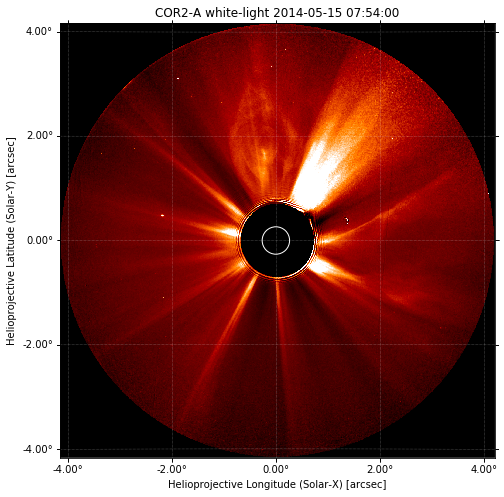

In [23]:
ax = plt.subplot(projection=cor2)
cor2.plot(vmin=0, vmax=600)
cor2.draw_limb()

lon, lat = ax.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

This plot is in the coordinate frame with respect to the observer location of the STEREO spacecraft. A number of bright object are also seen from this field of view. Let's see where the planets were at the time this image was taken to see if one of them might be in the field of view.

We have access to where this image was taken from

In [27]:
cor2.observer_coordinate

<SkyCoord (HeliographicStonyhurst: obstime=2014-05-15T07:54:00.005): (lon, lat, radius) in (deg, deg, m)
    (158.18219, 4.9816789, 1.4380171e+11)>

## Position of the planets

In [25]:
# Lets grab the positions of each of the planets in stonyhurt coordinates.
planet_list = ['earth', 'venus', 'mars', 'mercury', 'sun']
planet_coord = [get_body_heliographic_stonyhurst(this_planet, time=cor2.date) for this_planet in planet_list]

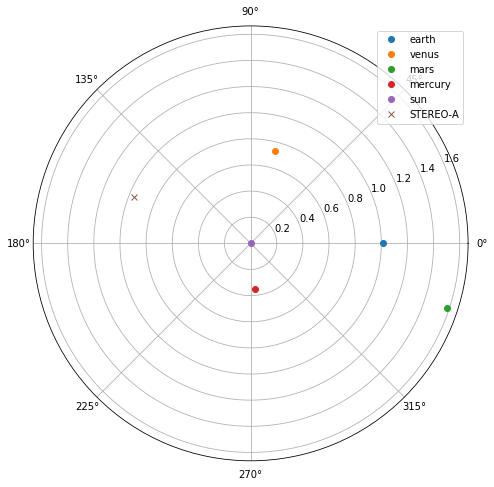

In [26]:
ax = plt.subplot(1, 1, 1, projection='polar')
for this_planet, this_coord in zip(planet_list, planet_coord):
    plt.polar(this_coord.lon.to('rad').value, this_coord.radius, 'o', label=this_planet)
plt.polar(cor2.observer_coordinate.lon.to('rad'), cor2.observer_coordinate.radius.to('au'), 'x', label='STEREO-A')
plt.legend()
plt.show()

It looks like Mars might be in the field of view. Let's check.

In [36]:
# get the location of mars
mars = get_body_heliographic_stonyhurst('mars', cor2.date, observer=cor2.observer_coordinate)
mars_hpc = mars.transform_to(cor2.coordinate_frame)

INFO: Apparent body location accounts for 1269.95 seconds of light travel time [sunpy.coordinates.ephemeris]


In [37]:
mars_hpc

<Helioprojective Coordinate (obstime=2014-05-15T07:54:00.005, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2014-05-15T07:54:00.005): (lon, lat, radius) in (deg, deg, m)
    (158.18219, 4.9816789, 1.4380171e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (-7870.72071699, 1713.81711738, 3.80721207e+08)>

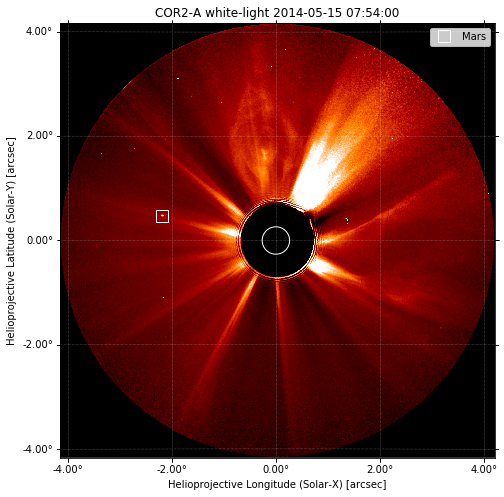

In [38]:
ax = plt.subplot(projection=cor2)
cor2.plot(vmin=0, vmax=600)
cor2.draw_limb()

lon, lat = ax.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax.plot_coord(mars_hpc, 's', color='white', fillstyle='none', markersize=12, label='Mars')
plt.legend()

## Getting Star fields

In [43]:
from astroquery.vizier import Vizier

In [48]:
###############################################################################
# To efficiently search the star field we need to know what stars are near the
# Sun as observed by STEREO. This can be found by find the difference vector
# between the Sun and the location of STEREO.
stereo = cor2.observer_coordinate.transform_to('icrs').cartesian
sun = get_body_barycentric('sun', time=cor2.date)
diff = sun - stereo
search_coord = SkyCoord(diff, frame='icrs')

In [51]:
vv=Vizier(columns=['**'], row_limit=-1, column_filters={'Gmag':'<7'}, timeout=1200)
vv.ROW_LIMIT = -1
result = vv.query_region(search_coord, radius=4 * u.deg, catalog='I/345/gaia2')

In [52]:
print(len(result[0]))

23


In [54]:
hpc_coords = []
for this_object in result[0]:
    tbl_crds = SkyCoord(this_object['RA_ICRS'] * u.deg, this_object['DE_ICRS'] * u.deg,
                                    1e12 * u.km, frame='icrs', obstime=cor2.date)
    hpc_coords.append(tbl_crds.transform_to(cor2.coordinate_frame))


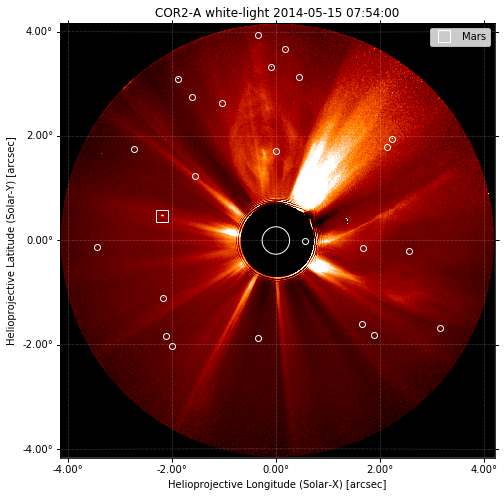

In [55]:
ax = plt.subplot(projection=cor2)
# let's tweak the axis to show in degrees instead of arcsec
lon, lat = ax.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
cor2.plot(axes=ax, vmin=0, vmax=600)
cor2.draw_limb()
# plot the mars position
ax.plot_coord(mars_hpc, 's', color='white', fillstyle='none', markersize=12, label='Mars')
# plot all of the stars.
for this_coord in hpc_coords:
    ax.plot_coord(this_coord, 'o', color='white', fillstyle='none')
plt.legend()
plt.show()

## Venus Transit

In [56]:
from astropy.utils.data import download_file
f = download_file('http://jsoc.stanford.edu/data/events/Venus_AIA24s_1600/Out/fits/20120606_040731_UTC.0041.fits')
aiamap = sunpy.map.Map(f)

For this example, we require high precision ephemeris information. The built-in
ephemeris provided by astropy are not accurate enough. This requires jplephem
to be installed.

In [60]:
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set('jpl')

<ScienceState solar_system_ephemeris: 'jpl'>

In [61]:
venus = get_body_heliographic_stonyhurst('venus', aiamap.date, observer=aiamap.observer_coordinate)
venus_hpc = venus.transform_to(aiamap.coordinate_frame)

INFO: Apparent body location accounts for 144.14 seconds of light travel time [sunpy.coordinates.ephemeris]


## Plotting on Map plots (WCSAxes)

WCSAxesSubplot(0.125,0.125;0.775x0.755)


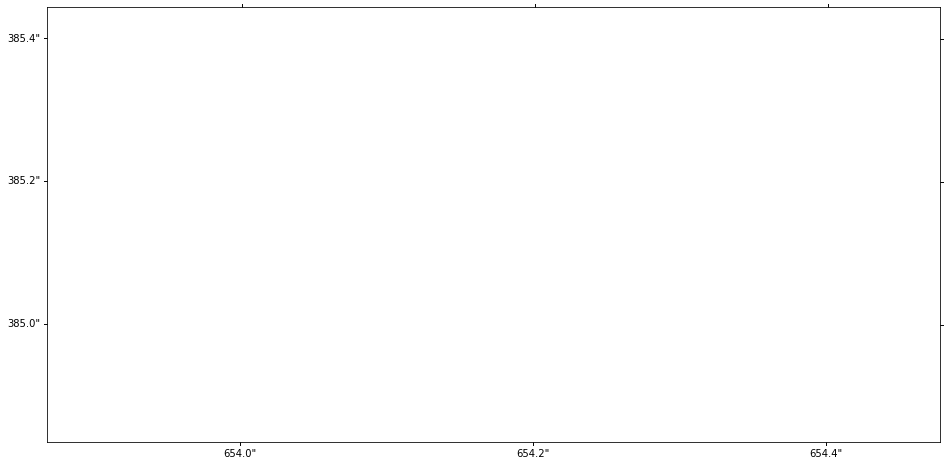

In [64]:
#ax = plt.subplot(111, projection=smap)
print(ax)

In [62]:
fov = 100 * u.arcsec
top_right = SkyCoord(venus_hpc.Tx + fov, venus_hpc.Ty + fov, frame=aiamap.coordinate_frame)
bottom_left = SkyCoord(venus_hpc.Tx - fov, venus_hpc.Ty - fov, frame=aiamap.coordinate_frame)
smap = aiamap.submap(top_right, bottom_left)

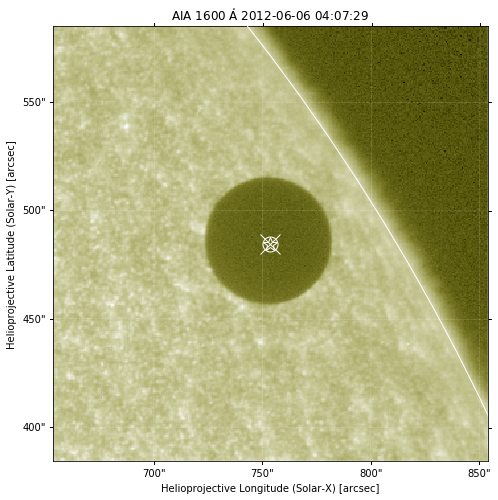

In [81]:
ax = plt.subplot(111, projection=smap)
smap.plot()
smap.draw_limb()

# using the plot_coord command provided by WCSAxes
ax.plot_coord(venus_hpc, 'x', color='white', markersize=20)

# plot in pixel coordinates
ax.plot(smap.world_to_pixel(venus_hpc).x, smap.world_to_pixel(venus_hpc).y, '*', color='white',
        fillstyle='none', markersize=15)

# plot in map coordinates
ax.plot(venus_hpc.Tx.to('deg'), venus_hpc.Ty.to('deg'), 'o', color='white', transform=ax.get_transform('world'),
       fillstyle='none', markersize=15)

plt.show()